In [1]:
import os
import pandas as pd
import numpy as np
import json
from google.colab import files
import io
from keras import layers
from keras import models
from keras import applications
from keras import optimizers
import keras

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


The code below is used to unzip the file containing data

In [0]:
!unzip -q "/content/drive/My Drive/Tadkamadla, Aashrith Sai"

I have checked if the file contains any file ending with **.json** and extracted all the **pose_keypoints_2d** and appended them into a data frame. I have taken only the co-ordinate values and not the probability of prediction from the openpose output.


In [402]:
i=1
path='/content/drive/My Drive/results data/newdata/60n.json'
#path='/content/12'
json_files=[pos_json for pos_json in os.listdir(path) if pos_json.endswith('.json')]
print('Found: ',len(json_files),'json keypoint frame files')
a=json.load(open(path+'/'+json_files[0]))
b=a['people']
q=b[0]['pose_keypoints_2d']
s=[p for p in q if p>1]
train=pd.DataFrame([s])
for j in range(1,len(json_files)):
    a=json.load(open(path+'/'+json_files[j]))
    b=a['people']
    if len(b)>0:
        q=b[0]['pose_keypoints_2d']
        s=[p for p in q if p>1]
        s=pd.DataFrame([s])
        train=train.append(s)
    else:
        continue

Found:  1817 json keypoint frame files


The next code is used to clean the data and I have used **method='ffill'** to get the same values as the previous rows if there are NaN values. I have also handled the case where the pose_keypoints_2d are detected to be less than 50 features. I have made them equal to zero as often the keypoints of the toe are not properly detected and my model is not going to get affected by these values. 

In [0]:
train=train.fillna(method='ffill')
train=train.fillna(0)
y,x=train.shape
s=np.zeros(y)
s=pd.DataFrame(s)

for i in range(50):
    y,x=train.shape
    if x!=50:
        train[x]=s
        x=x+1
    if y<90:
        train=train.append(train.iloc[y-1])

for i in range(50):
    train.iloc[:,i]=train.iloc[:,i]/train.iloc[:,i].max()

In [404]:
train=train.fillna(method='ffill')
train=train.fillna(0)
train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0.972077,0.832703,0.985654,0.811077,0.967984,0.811461,0.942178,0.826878,0.920379,0.838417,0.591681,0.720904,0.789363,0.720454,0.742349,0.680260,0.596553,0.769347,0.586896,0.837247,0.743154,0.768812,0.897135,0.673256,0.559046,0.647963,0.694504,0.664812,0.898278,0.654490,0.279436,0.787103,0.276844,0.734641,0.260217,0.694568,0.832820,0.777526,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
0,0.972317,0.832744,0.995036,0.811008,0.972364,0.811397,0.955745,0.827034,0.917614,0.844230,0.591692,0.735462,0.778259,0.724370,0.749031,0.683990,0.592935,0.789404,0.581550,0.847047,0.736201,0.788259,0.890255,0.695429,0.559031,0.663765,0.701058,0.748604,0.288123,0.787107,0.277775,0.743959,0.303785,0.790114,0.260188,0.700714,0.832820,0.777526,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
0,0.977680,0.842868,0.999861,0.824841,0.999816,0.814226,0.959095,0.844688,0.898404,0.855983,0.594576,0.750229,0.806253,0.751180,0.757889,0.734824,0.585759,0.819467,0.579771,0.869827,0.677220,0.817662,0.564434,0.711345,0.705490,0.748557,0.825168,0.720693,0.289851,0.805574,0.277757,0.750083,0.302057,0.808628,0.260120,0.707051,0.832820,0.777526,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
0,0.966795,0.849490,1.000000,0.828211,1.000000,0.814382,0.955768,0.844771,0.901154,0.856058,0.594633,0.750354,0.806248,0.751191,0.757866,0.742034,0.587519,0.826157,0.577955,0.869838,0.685877,0.827423,0.859383,0.743000,0.557355,0.710848,0.686384,0.733211,0.860400,0.725313,0.279450,0.808677,0.276803,0.753241,0.284050,0.814980,0.259746,0.843271,0.864605,0.793775,0.880155,0.801602,0.825434,0.830493,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
0,0.966698,0.852840,0.999965,0.831560,0.999907,0.817220,0.955779,0.844731,0.903892,0.858805,0.594567,0.753825,0.797759,0.754880,0.755640,0.742203,0.596539,0.819469,0.585122,0.863302,0.718829,0.837133,0.873097,0.733527,0.562402,0.710773,0.687999,0.739361,0.872464,0.716096,0.281094,0.808778,0.276723,0.768459,0.285704,0.808855,0.259710,0.850518,0.862978,0.790243,0.880161,0.794542,0.840252,0.823493,0.884487,0.781868,0.920707,0.807901,0.943079,1.0


For training the network I had to manually assign the output values to be classified as zero or one.

In [0]:
r=np.zeros(20)
t=np.ones(0)
r=r.tolist()
t=t.tolist()
train_y=t+r
#train_y=np.array(train_y)

I have given one output for 90 frames and hence always taken the input data as multiples of 90.

In [0]:
train=train.iloc[:1800,:]

In [0]:
#finalx=train
finalx=finalx.append(train)

In [409]:
finalx.shape

(49770, 50)

In [0]:
#finaly=train_y
finaly+=train_y

In [411]:
len(finaly)

553

Reshaping the values as **(Samples,Timesteps,Features)** using numpys reshape method

In [0]:
X=finalx.values
X=X.reshape(553,90,50)
Y=np.array(finaly)
Y=Y.reshape(553,1)

I have taken **0.33** as the training and validation split using **train_test_split** from **sklearn.model_selection**

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [414]:
X_train.shape

(370, 90, 50)

I have used callbacks for **model checkpointing** and **early stopping**

In [0]:
from keras.callbacks import EarlyStopping
from keras import regularizers
checkpoint_path='/content/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
callbacks_list=keras.callbacks.ModelCheckpoint(checkpoint_path,save_weights_only=False,save_best_only=True,monitor='loss')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=30)

**Model Architecture**

In [0]:
model = models.Sequential()
model.add(layers.LSTM(units=90,return_sequences=True,input_shape=(90,50)))
model.add(layers.Dropout(0.5))
model.add(layers.LSTM(units=90,input_shape=(90,50)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(units=90,activation='relu',kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))
model.add(layers.Dense(units=1, activation='sigmoid'))

I have used Adam optimizer and have manually checked the learning rate and selected 0.0001 as the best fit.

In [0]:
adam=keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])

Training the model to 500 epochs using the batch size of 5

In [443]:
history=model.fit(X_train,y_train,epochs=500,callbacks=[callbacks_list],validation_data=(X_test,y_test),batch_size=5)

Train on 370 samples, validate on 183 samples
Epoch 1/500
370/370 [==============================] - 17s 47ms/step - loss: 1.7440 - acc: 0.5108 - val_loss: 1.5648 - val_acc: 0.5082
Epoch 2/500
370/370 [==============================] - 12s 31ms/step - loss: 1.5717 - acc: 0.5135 - val_loss: 1.4826 - val_acc: 0.5464
Epoch 3/500
370/370 [==============================] - 11s 31ms/step - loss: 1.4782 - acc: 0.5676 - val_loss: 1.4127 - val_acc: 0.5902
Epoch 4/500
370/370 [==============================] - 12s 31ms/step - loss: 1.4035 - acc: 0.5351 - val_loss: 1.3478 - val_acc: 0.5628
Epoch 5/500
370/370 [==============================] - 11s 30ms/step - loss: 1.3319 - acc: 0.5486 - val_loss: 1.2867 - val_acc: 0.5628
Epoch 6/500
370/370 [==============================] - 11s 30ms/step - loss: 1.2683 - acc: 0.5730 - val_loss: 1.2294 - val_acc: 0.5574
Epoch 7/500
370/370 [==============================] - 11s 31ms/step - loss: 1.2103 - acc: 0.6108 - val_loss: 1.1762 - val_acc: 0.5519
Epoch 8/5

In [427]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 90, 90)            50760     
_________________________________________________________________
dropout_13 (Dropout)         (None, 90, 90)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 90)                65160     
_________________________________________________________________
dropout_14 (Dropout)         (None, 90)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 90)                8190      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 91        
Total params: 124,201
Trainable params: 124,201
Non-trainable params: 0
________________________________________________

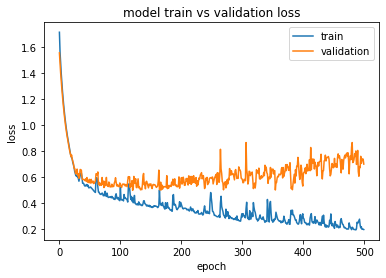

In [419]:
import matplotlib.pyplot as pyplot
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

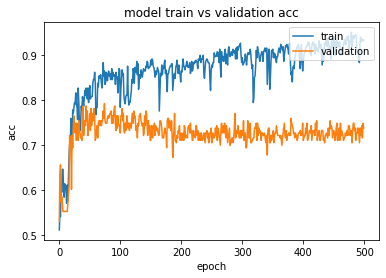

In [425]:
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation acc')
pyplot.ylabel('acc')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [0]:
model.save('../content/wall1')

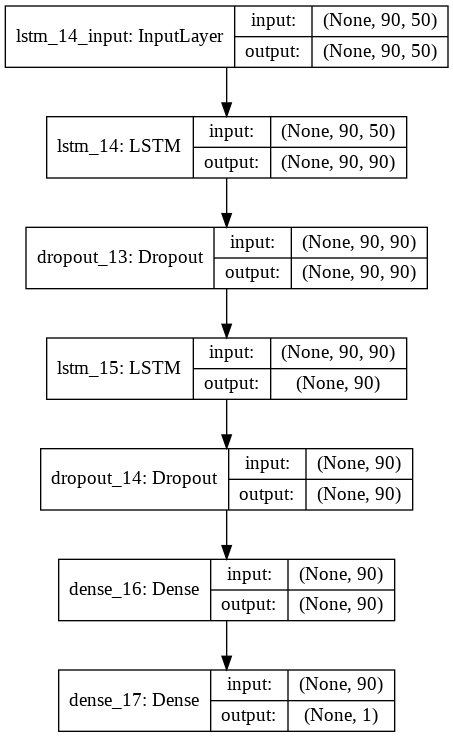

In [436]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)